# Analysing H1B Acceptance Trends 

H1B visa is a nonimmigrant visa issued to gradute level workers which allows them to work in the United States. The employer sponsors the H1B visa for workers with theoretical or technical expertise in specialized fields such as in IT, finance, accounting etc. An interesting fact about immigrant workers is that about 52 percent of new Silicon valley companies were founded by such workers during 1995 and 2005. Some famous CEOs like Indira Nooyi (Pepsico), Elon Musk (Tesla), Sundar Pichai (Google),Satya Nadella (Microsoft) once arrived to the US on a H1B visa.

**Motivation**: Our team consists of five international gradute students, in the future we will be applying for H1B visa. The visa application process seems very long, complicated and uncertain. So we decided to understand this process and use Machine learning algorithms to predict the acceptance rate and trends of H1B visa. 

## Data 
The data used in the project has been collected from <a href="https://www.foreignlaborcert.doleta.gov/performancedata.cfm">the Office of Foreign Labor Certification (OFLC).</a> 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:

!pip install autocorrect
import nltk
from textblob import TextBlob
from autocorrect import Speller 
nltk.download('wordnet')
import pandas as pd
import numpy as np
import warnings

## Exploratory Data Analysis

Before we begin working on our data we need to understand the traits of our data which we accomplish using EDA. We see that we have about 260 columns , not all 260 columns have essential information that contributes to our analysis. Hence we pick out the columns such as case status( Accepted/ Denied) ,Employer, Job title etc. 

In [222]:
#Read the csv file and stored in file
#file=pd.read_csv('/content/gdrive/My Drive/H-1B_Disclosure_Data_FY2019.csv')
file=pd.read_csv('../data/H-1B_Disclosure_Data_FY2019.csv')

C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,13,14,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,57,58,59,61,64,66,67,68,69,70,71,72,73,76,78,79,80,82,85,87,88,89,90,91,92,93,94,97,98,99,100,101,103,106,108,109,110,111,112,113,114,115,121,122,124,127,129,130,131,132,133,134,135,136,142,143,145,148,150,151,152,153,154,155,156,157,160,162,163,164,166,169,171,172,173,174,175,176,177,178,184,185,187,190,192,193,194,195,196,197,198,199,205,206,208,211,213,214,215,216,217,218,219,220,223,225,226,227,229,232,234,235,236,237,238,239,240,244,246,247,248,250,253,254,255,256,257,258,259) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [223]:
file.shape

(1048548, 260)

In [224]:
cleaned=file[['CASE_NUMBER','CASE_STATUS','CASE_SUBMITTED','DECISION_DATE','VISA_CLASS','FULL_TIME_POSITION','JOB_TITLE','SOC_CODE','SOC_TITLE',\
              'EMPLOYER_NAME','WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1','NAICS_CODE','WORKSITE_CITY_1','WORKSITE_STATE_1']]
cleaned.head()

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,FULL_TIME_POSITION,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WAGE_RATE_OF_PAY_FROM_1,WAGE_UNIT_OF_PAY_1,NAICS_CODE,WORKSITE_CITY_1,WORKSITE_STATE_1
0,I-200-16092-327771,WITHDRAWN,4/8/2016,4/30/2019,H-1B,Y,ASSOCIATE CREATIVE DIRECTOR,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"R/GA MEDIA GROUP, INC.","$179,000.00",Year,541810.0,NEW YORK,NY
1,I-203-17188-450729,WITHDRAWN,7/14/2017,5/13/2019,E-3 Australian,Y,ACCOUNT SUPERVISOR (MOTHER),11-2011,ADVERTISING AND PROMOTIONS MANAGERS,MOTHER INDUSTRIES LLC,"$110,000.00",Year,541810.0,NEW YORK,NY
2,I-203-17229-572307,WITHDRAWN,8/23/2017,4/30/2019,E-3 Australian,Y,EXECUTIVE CREATIVE DIRECTOR,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"WE ARE UNLIMITED, INC.","$275,000.00",Year,541810.0,CHICAGO,IL
3,I-203-17356-299648,WITHDRAWN,12/22/2017,8/20/2019,E-3 Australian,Y,PROJECT MANAGEMENT LEAD,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"HELLO ELEPHANT, LLC","$140,000.00",Year,541810.0,BROOKLYN,NY
4,I-203-18008-577576,WITHDRAWN,1/10/2018,4/15/2019,E-3 Australian,Y,"CREATIVE DIRECTOR, UX",11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"HELLO ELEPHANT, LLC","$180,000.00",Year,541810.0,BROOKLYN,NY


In [225]:
cleaned.shape

(1048548, 15)

In [226]:
cleaned['VISA_CLASS'].value_counts()

H-1B               649083
E-3 Australian      13087
H-1B1 Singapore      1291
H-1B1 Chile          1155
Name: VISA_CLASS, dtype: int64

In [227]:
# Visa class has many categories which are not of use , we require only H1B visa type , hence we drop all records with other visa types
cleaned.drop(labels=cleaned.loc[cleaned['VISA_CLASS']!='H-1B'].index , inplace=True)

C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [228]:
cleaned['FULL_TIME_POSITION'].value_counts()

Y    638346
N     10737
Name: FULL_TIME_POSITION, dtype: int64

In [229]:
cleaned['CASE_STATUS'].value_counts()

CERTIFIED              578640
CERTIFIED-WITHDRAWN     46050
WITHDRAWN               19227
DENIED                   5166
Name: CASE_STATUS, dtype: int64

In [230]:
#As we want to only need accepted and denied cases we are dropping withdrawn from the data frame. 
#Case status of class certified-withdraw were certified earlier and later withdraw which can be considered a
cleaned.replace({"CASE_STATUS":"CERTIFIED-WITHDRAWN"},"CERTIFIED",inplace=True)
cleaned.drop(labels=cleaned.loc[cleaned['CASE_STATUS']=='WITHDRAWN'].index , inplace=True)
cleaned.head()

C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,FULL_TIME_POSITION,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WAGE_RATE_OF_PAY_FROM_1,WAGE_UNIT_OF_PAY_1,NAICS_CODE,WORKSITE_CITY_1,WORKSITE_STATE_1
18,I-200-17250-072640,CERTIFIED,9/7/2017,1/7/2019,H-1B,Y,"EXECUTIVE DIRECTOR, STRATEGY",11-2011,ADVERTISING AND PROMOTIONS MANAGERS,FIGLIULO & PARTNERS LLC,"$230,000.00",Year,541810.0,NEW YORK,NY
19,I-200-18026-717110,CERTIFIED,1/26/2018,7/5/2019,H-1B,Y,PROJECT OPERATIONS MANAGER,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,INVISIONAPP INC.,"$107,000.00",Year,541511.0,SAN FRANCISCO,CA
21,I-200-18039-081565,CERTIFIED,3/5/2018,1/8/2019,H-1B,Y,MANAGER OF LEAGUE AND TOURNAMENT SERVICES,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,OREGON YOUTH SOCCER ASSOCIATION,"$49,087.00",Year,61162.0,BEAVERTON,OR
22,I-200-18082-340860,CERTIFIED,3/23/2018,4/22/2019,H-1B,Y,"DIRECTOR, DEMAND",11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"FACTUAL, INC.","$172,930.00",Year,511210.0,NEW YORK,NY
24,I-200-18162-689783,CERTIFIED,9/26/2018,10/2/2018,H-1B,N,ADVERSTING AND PROMOTIONS MANAGER,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,FANTUAN GROUP INC,$33.00,Hour,511210.0,CHICAGO,IL


In [ ]:
#cleaned.info()

In [231]:
#the column wages has a mix of both string and float value types and some record have the symbol '$' which we want to remove
cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(type).value_counts()

<class 'float'>    460442
<class 'str'>      169414
Name: WAGE_RATE_OF_PAY_FROM_1, dtype: int64

In [ ]:
cleaned['WORKSITE_STATE_1'].apply(type).value_counts()

In [232]:
def clean_wages(w):
    """ Function to remove '$' symbol and other delimiters from wages column which consistes of str and float type values
    if the column entry is string type then remove the symbols else return the column value as it is 
    """
    if isinstance(w, str):
        return(w.replace('$', '').replace(',', ''))
    return(w)

In [233]:
cleaned['WAGES']=cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(clean_wages).astype('float')
#cleaned.info()

C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [234]:
# the wage information that we have available has different unit of pay
cleaned['WAGE_UNIT_OF_PAY_1'].value_counts()

Year         587386
Hour          41927
Month           342
Bi-Weekly       105
Week             92
Name: WAGE_UNIT_OF_PAY_1, dtype: int64

In [235]:
# we convert the different units of pay to the type 'Year'
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Month',cleaned['WAGES'] * 12,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Hour',cleaned['WAGES'] * 2080,cleaned['WAGES']) # 2080=8 hours*5 days* 52 weeks
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Bi-Weekly',cleaned['WAGES'] *26,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Week',cleaned['WAGES'] * 52,cleaned['WAGES'])

C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:4: Set

In [236]:
#As we have got the information of Wages and made transformation we can drop the initial two records
cleaned.drop(columns=['WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1'],axis=1,inplace=True)


In [237]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629856 entries, 18 to 664616
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CASE_NUMBER         629855 non-null  object 
 1   CASE_STATUS         629856 non-null  object 
 2   CASE_SUBMITTED      629856 non-null  object 
 3   DECISION_DATE       629856 non-null  object 
 4   VISA_CLASS          629856 non-null  object 
 5   FULL_TIME_POSITION  629856 non-null  object 
 6   JOB_TITLE           629856 non-null  object 
 7   SOC_CODE            629852 non-null  object 
 8   SOC_TITLE           629852 non-null  object 
 9   EMPLOYER_NAME       629848 non-null  object 
 10  NAICS_CODE          629855 non-null  float64
 11  WORKSITE_CITY_1     629785 non-null  object 
 12  WORKSITE_STATE_1    629845 non-null  object 
 13  WAGES               629852 non-null  float64
dtypes: float64(2), object(12)
memory usage: 72.1+ MB


In [238]:
"""
We should remove record that have null objects, from the above cell we see
that all columns don't have same number of non-null records
which means we have to remove the records that have the null values.
we see that there are about 17 records that have null values
""" 
null_rows = cleaned.isnull().any(axis=1)
print(cleaned[null_rows].shape)
print(cleaned.shape)

(92, 14)
(629856, 14)


In [239]:
cleaned.dropna(inplace=True)
print(cleaned.shape)

(629764, 14)


C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#cleaned['JOB_TITLE'].value_counts()

In [240]:
#we see that the job title has integers(words with integers also) 
#removing comma also
def remove_num(text):
  if not any(c.isdigit() for c in text):
    return text
  return ''
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([remove_num(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE']=cleaned['JOB_TITLE'].str.replace(',', '')
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([remove_num(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned['SOC_TITLE'].str.replace(',', '')
print("Numbers and strings with numbers removed" )
#cleaned.head()
#cleaned['JOB_TITLE'].value_counts()

C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Numbers and strings with numbers removed


C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [249]:
nltk.download('words')
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())
spell = Speller()


def lemmatize_text(text):
  return lemmatizer.lemmatize(text)

def spelling_checker(text):
  return spell(text)
 
print(spelling_checker("computr sciece progam check"))

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Charic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


computer science program check


In [250]:
#this part takes more time because spell_checker 
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
print(' JOB_TITLE IS  lemmatized')
#print(cleaned['JOB_TITLE'].value_counts() 

 JOB_TITLE IS  lemmatized


C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [257]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))
print('JOB_TITLE SPELLING MISTAKES RECTIFIED')

JOB_TITLE SPELLING MISTAKES RECTIFIED


C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [258]:
#clean SOC TITLE
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))
print('SOC_TITLE SPELLING MISTAKES RECTIFIED')
cleaned = cleaned.groupby("SOC_TITLE").filter(lambda x: len(x) > 15)
print(" removing least significant values from SOC_TITLE")
#cleaned['SOC_TITLE'].value_counts()

C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Charic\Documents\Python_Scripts\2_semester\data_science_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


SOC_TITLE SPELLING MISTAKES RECTIFIED
 removing least significant values from SOC_TITLE


In [259]:
cleaned = cleaned.groupby("SOC_CODE").filter(lambda x: len(x) > 15)
print("DROPPING THE LEAST SIGNIFICANT EMPLYOERS")
#cleaned['SOC_CODE'].value_counts()

DROPPING THE LEAST SIGNIFICANT EMPLYOERS


In [ ]:
#we see that the job title has integers in the record which we can remove
#handeled above
#so commenting this part
#cleaned['JOB_TITLE']=cleaned['JOB_TITLE'].str.replace('[0-9(){}[].]', '')
#cleaned.head()

In [260]:
cleaned['SOC_TITLE'].value_counts()

software developer application                                208679
computer system analyst                                        71186
computer occupation all other                                  54484
software developer system software                             30593
computer programmer                                            16622
                                                               ...  
agent and business manager of artist performer and athlete        16
mechanical engineer non-r&d                                       16
database architect                                                16
electrical engineer non-r&d                                       16
regulatory affair specialist                                      10
Name: SOC_TITLE, Length: 320, dtype: int64

In [261]:
cleaned['EMPLOYER_NAME'].value_counts()
cleaned = cleaned.groupby("EMPLOYER_NAME").filter(lambda x: len(x) > 15)
print("DROPPING THE LEAST SIGNIFICANT EMPLYOERS")
#cleaned['EMPLOYER_NAME'].value_counts()

DROPPING THE LEAST SIGNIFICANT EMPLYOERS


In [262]:
Top_Employer=cleaned['EMPLOYER_NAME'].value_counts()[:10]
Top_Employer

COGNIZANT TECHNOLOGY SOLUTIONS US CORP    28103
INFOSYS LIMITED                           21401
TATA CONSULTANCY SERVICES LIMITED         11839
GOOGLE LLC                                 9557
ERNST & YOUNG U.S. LLP                     8661
CAPGEMINI AMERICA INC                      7796
DELOITTE CONSULTING LLP                    7620
AMAZON.COM SERVICES, INC.                  6771
MICROSOFT CORPORATION                      5887
ACCENTURE LLP                              5584
Name: EMPLOYER_NAME, dtype: int64

In [263]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

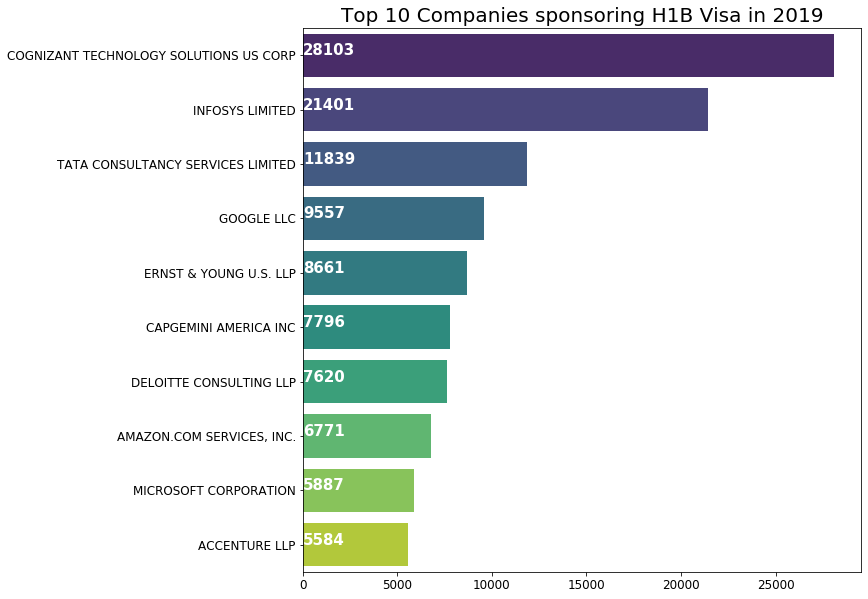

In [264]:
plt.figure(figsize=[10,10])
ax=sns.barplot(y=Top_Employer.index,x=Top_Employer.values,palette=sns.color_palette('viridis',10))
ax.tick_params(labelsize=12)
for i, v in enumerate(Top_Employer.values): 
    ax.text(.5, i, v,fontsize=15,color='white',weight='bold')
plt.title('Top 10 Companies sponsoring H1B Visa in 2019', fontsize=20)
plt.show()

In [265]:
def wage_feature_eng(wage):
    if wage <=50000:
        return "VERY LOW"
    elif wage in range(50000,75000):
        return "LOW"
    elif wage in range(75000,100000):
        return "AVERAGE"
    elif wage in range(100000,150000):
        return "HIGH"
    elif wage >=150000:
        return "VERY HIGH"

In [266]:
cleaned['WAGE_CATEGORY'] = cleaned['WAGES'].apply(wage_feature_eng)
cleaned.head()

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,FULL_TIME_POSITION,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,NAICS_CODE,WORKSITE_CITY_1,WORKSITE_STATE_1,WAGES,WAGE_CATEGORY
47,I-200-18299-123963,CERTIFIED,10/26/2018 17:31:16,11/01/2018 22:00:49,H-1B,Y,program manager i,11-2011,advertising and promotion manager,UNIVERSITY OF TEXAS AT DALLAS,611310.0,RICHARDSON,TX,67500.0,LOW
54,I-200-18317-440186,CERTIFIED,11/13/2018 20:06:33,11/19/2018 22:00:55,H-1B,Y,advertising and promotion manager,11-2011,advertising and promotion manager,APPLE INC.,334111.0,CUPERTINO,CA,97781.0,AVERAGE
55,I-200-18317-855371,CERTIFIED,11/13/2018 20:07:01,11/19/2018 22:00:55,H-1B,Y,advertising and promotion manager,11-2011,advertising and promotion manager,APPLE INC.,334111.0,CUPERTINO,CA,126901.0,HIGH
56,I-200-18317-109580,CERTIFIED,11/13/2018 20:07:34,11/19/2018 22:00:55,H-1B,Y,advertising and promotion manager,11-2011,advertising and promotion manager,APPLE INC.,334111.0,CUPERTINO,CA,156021.0,VERY HIGH
72,I-200-18334-445862,CERTIFIED,12/3/2018 14:26,12/10/2018 22:00,H-1B,Y,and writing,11-2011,advertising and promotion manager,APPLE INC.,334111.0,Sunnyvale,CALIFORNIA,154232.0,VERY HIGH


In [267]:
cleaned.columns

Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
       'VISA_CLASS', 'FULL_TIME_POSITION', 'JOB_TITLE', 'SOC_CODE',
       'SOC_TITLE', 'EMPLOYER_NAME', 'NAICS_CODE', 'WORKSITE_CITY_1',
       'WORKSITE_STATE_1', 'WAGES', 'WAGE_CATEGORY'],
      dtype='object')

In [268]:
print("BEFORE CLEANING THE WORKSITE_STATE_1 COLUMN")
cleaned["WORKSITE_STATE_1"].value_counts()

BEFORE CLEANING THE WORKSITE_STATE_1 COLUMN


CALIFORNIA          80576
TEXAS               43635
NEW YORK            28640
NEW JERSEY          26444
ILLINOIS            21527
                    ...  
PR                      6
VIRGIN ISLANDS          4
PW                      1
VI                      1
MARSHALL ISLANDS        1
Name: WORKSITE_STATE_1, Length: 110, dtype: int64

In [269]:
# Code to clean the "WORKSITE_STATE_1" column because some of the values are abbrevations and some of them are names
#So changed to names as most of the values are names.   
print("AFTER CLEANING THE WORKSITE_STATE_1 COLUMN")

cleaned.loc[(cleaned.WORKSITE_STATE_1 == "AL"),"WORKSITE_STATE_1"] = "ALABAMA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "AK"),"WORKSITE_STATE_1"] = "ALASKA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "AZ"),"WORKSITE_STATE_1"] = "ARIZONA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "AR"),"WORKSITE_STATE_1"] = "ARKANSAS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "CA"),"WORKSITE_STATE_1"] = "CALIFORNIA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "CO"),"WORKSITE_STATE_1"] = "COLORADO"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "DE"),"WORKSITE_STATE_1"] = "DELAWARE"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "FL"),"WORKSITE_STATE_1"] = "FLORIDA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "GA"),"WORKSITE_STATE_1"] = "GEORGIA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "HI"),"WORKSITE_STATE_1"] = "HAWAII"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "ID"),"WORKSITE_STATE_1"] = "IDAHO"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "IL"),"WORKSITE_STATE_1"] = "ILLINOIS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "IN"),"WORKSITE_STATE_1"] = "INDIANA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "IA"),"WORKSITE_STATE_1"] = "IOWA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "KS"),"WORKSITE_STATE_1"] = "KANSAS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "KY"),"WORKSITE_STATE_1"] = "KENTUCKY"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "LA"),"WORKSITE_STATE_1"] = "LOUISIANA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "ME"),"WORKSITE_STATE_1"] = "MAINE"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MD"),"WORKSITE_STATE_1"] = "MARYLAND"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MA"),"WORKSITE_STATE_1"] = "MASSACHUSETTS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MI"),"WORKSITE_STATE_1"] = "MICHIGAN"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MN"),"WORKSITE_STATE_1"] = "MINNESOTA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MS"),"WORKSITE_STATE_1"] = "MISSISSIPPI"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MO"),"WORKSITE_STATE_1"] = "MISSOURI"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MT"),"WORKSITE_STATE_1"] = "MONTANA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "NE"),"WORKSITE_STATE_1"] = "NEBRASKA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "NV"),"WORKSITE_STATE_1"] = "NEVADA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "NH"),"WORKSITE_STATE_1"] = "NEW HAMPSHIRE"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "NJ"),"WORKSITE_STATE_1"] = "NEW JERSEY"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "NM"),"WORKSITE_STATE_1"] = "NEW MEXICO"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "NY"),"WORKSITE_STATE_1"] = "NEW YORK"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "NC"),"WORKSITE_STATE_1"] = "NORTH CAROLINA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "ND"),"WORKSITE_STATE_1"] = "NORTH DAKOTA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "OH"),"WORKSITE_STATE_1"] = "OHIO"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "OK"),"WORKSITE_STATE_1"] = "OKLAHOMA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "OR"),"WORKSITE_STATE_1"] = "OREGON"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "PA"),"WORKSITE_STATE_1"] = "PENNSYLVANIA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "RI"),"WORKSITE_STATE_1"] = "RHODE ISLAND"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "SC"),"WORKSITE_STATE_1"] = "SOUTH CAROLINA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "SD"),"WORKSITE_STATE_1"] = "SOUTH DAKOTA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "TN"),"WORKSITE_STATE_1"] = "TENNESSEE"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "TX"),"WORKSITE_STATE_1"] = "TEXAS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "UT"),"WORKSITE_STATE_1"] = "UTAH"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "VT"),"WORKSITE_STATE_1"] = "VERMONT"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "VA"),"WORKSITE_STATE_1"] = "VIRGINIA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "WA"),"WORKSITE_STATE_1"] = "WASHINGTON"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "WV"),"WORKSITE_STATE_1"] = "WEST VIRGINIA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "WI"),"WORKSITE_STATE_1"] = "WISCONSIN"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "WY"),"WORKSITE_STATE_1"] = "WYOMING"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "PR"),"WORKSITE_STATE_1"] = "PUERTO RICO"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "VI"),"WORKSITE_STATE_1"] = "U.S. VIRGIN ISLANDS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MP"),"WORKSITE_STATE_1"] = "NORTHERN MARIANA ISLANDS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "GU"),"WORKSITE_STATE_1"] = "GUAM"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "MH"),"WORKSITE_STATE_1"] = "MARSHALL ISLANDS"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "PW"),"WORKSITE_STATE_1"] = "PALAU"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "DC"),"WORKSITE_STATE_1"] = "DISTRICT OF COLUMBIA"
cleaned.loc[(cleaned.WORKSITE_STATE_1 == "CT"),"WORKSITE_STATE_1"] = "CONNECTICUT"


AFTER CLEANING THE WORKSITE_STATE_1 COLUMN


In [270]:
cleaned["WORKSITE_STATE_1"].value_counts()
print("CONVERTING CATEGORICAL COLUMNS INTO NUMERIC COLUMNS")

CONVERTING CATEGORICAL COLUMNS INTO NUMERIC COLUMNS


In [271]:
cleaned = cleaned.groupby("WORKSITE_STATE_1").filter(lambda x: len(x) > 15)
print("DROPPING LEAST SIGNIFICANT STATES")
#cleaned["WORKSITE_STATE_1"].value_counts()

DROPPING LEAST SIGNIFICANT STATES


In [272]:
#CONVERTING CATEGORICAL COLUMNS INTO NUMERIC COLUMNS
print(cleaned["CASE_STATUS"].value_counts())
cleaned.loc[(cleaned.CASE_STATUS == "CERTIFIED"),"CASE_STATUS"] = 1
cleaned.loc[(cleaned.CASE_STATUS == "DENIED"),"CASE_STATUS"] = 0
print(cleaned["CASE_STATUS"].value_counts())

CERTIFIED    477691
DENIED         2200
Name: CASE_STATUS, dtype: int64
1    477691
0      2200
Name: CASE_STATUS, dtype: int64


In [273]:
print(cleaned["FULL_TIME_POSITION"].value_counts())
cleaned.loc[(cleaned.FULL_TIME_POSITION == "Y"),"FULL_TIME_POSITION"] = 1
cleaned.loc[(cleaned.FULL_TIME_POSITION == "N"),"FULL_TIME_POSITION"] = 0
print(cleaned["FULL_TIME_POSITION"].value_counts())

Y    477323
N      2568
Name: FULL_TIME_POSITION, dtype: int64
1    477323
0      2568
Name: FULL_TIME_POSITION, dtype: int64


### Baseline classifier

The baseline classifier is done with a basic model. In this case we are taking the mean of the labels ('certified' and 'denied' for H1B visa approvals). It will give us the base accuracy to which we will compare our classifier's accuracy. Our classifier should have a better accuracy than the baseline classifier accuracy.


In [340]:
# This step assigns a binary class label (0 or 1) to each label for H1B visa approval. 
#'CERTIFIED' is mapped to 1 and 'DENIED' to 0

def create_class_labels(processed_data):
    
    y = np.where((processed_data['CASE_STATUS']== 1),1, 0)
    
    return y

X = cleaned['CASE_STATUS'].to_numpy()

# Groundtruth labels for the dataset
y = create_class_labels(cleaned)
counts = cleaned['CASE_STATUS'].value_counts()
print(counts)
print('proportion: ', counts[1]/counts[0], ': 1')

1    477691
0      2200
Name: CASE_STATUS, dtype: int64
proportion:  217.13227272727272 : 1


In [320]:
import sklearn
from statistics import mean

# Baseline classifier that predicts the class base on the mode of the labels.

class BaselineClasifier():
    
    def __init__(self):
        self.central_tendency = None
        
    def fit(self, data, y, central_t='mode'): 
        
        # Count labels and find the most frequent one
        label, counts = np.unique(y, return_counts=True) 
        
        if central_t == 'mode':
            self.central_tendency = counts.argmax()
        elif central_t == 'mean':
            self.central_tendency = round(np.sum(y)/len(y))
        
        return self
    
    # Return an array with size equal to the data size  and each element setted to the mode.
    def predict(self, data):
        
        result = np.full(data.shape[0], self.central_tendency)
        
        return result

In [321]:
def compute_accuracy(validation, predicted):
    
    comp = prediction == validation 
    match_counts = np.count_nonzero(comp == True) 
    clasifier_accuracy = match_counts/len(validation)
    
    return clasifier_accuracy
    

In [329]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

def compute_AUC(y, prediction):
    
    auc = None
    
    try:
        auc = roc_auc_score(y, prediction)
    except ValueError:
        pass

    return auc

In [338]:
from sklearn import model_selection

# Testing with K-folds

accuracies = []
AUCs = []

kf = sklearn.model_selection.KFold(n_splits=4, random_state=1, shuffle=True) 

for train_idx, test_idx in kf.split(X):
    
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx] 
    baseline_clasifier = BaselineClasifier()
    classifier = baseline_clasifier.fit(X_train, y_train, 'mean')
    prediction = baseline_clasifier.predict(X_test)
    
    fold_accuracy = compute_accuracy(y_test, prediction)
    fold_AUC = compute_AUC(y_test, prediction)   
    accuracies.append(fold_accuracy)
    if fold_AUC != None: AUCs.append(fold_AUC)
    
baseline_clasifier_accuracy = mean(accuracies)

print('Baseline accuracy: ', baseline_clasifier_accuracy) 

Baseline accuracy:  0.9954156255100106


In [334]:
from sklearn.model_selection import train_test_split

# Testing with regular split

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
baseline_clasifier = BaselineClasifier()
classifier = baseline_clasifier.fit(X_train, y_train, 'mean')
prediction = baseline_clasifier.predict(X_test)

split_accuracy = compute_accuracy(y_test, prediction)
split_AUC = compute_AUC(y_test, prediction)

print('Baseline accuracy: ', split_accuracy)  

Baseline accuracy:  0.9953948259515102


The accuracy results of the baseline classifier is 0.99. This result is due to the highly imbalanced data, where there are 477691 CERTIFIED applications and 2200 DENIED applications. The proportion of it is 217.132272 to 1. Therefore, a performance measure based on the accuracy is not a good one. A better performance measure in imbalanced data is the Area under the ROC Curve (AUC). It meassures the likelihood that given two random points (one from the positive and one from the negative class) the classifier will rank the point from the positive class higher than the one from the negative one.

In [339]:
print('K-fold: ', mean(AUCs))
print('split (80-20): ', split_AUC)

K-fold:  0.5
split (80-20):  0.5


In [ ]:
Dataset = cleaned[["CASE_STATUS", "FULL_TIME_POSITION","JOB_TITLE", "SOC_CODE", "SOC_TITLE", "EMPLOYER_NAME", "WORKSITE_STATE_1", "WAGE_CATEGORY"]]
Dataset.head()

In [ ]:
#Considered top positions in job roles
Top_Job_positions = Dataset["JOB_TITLE"].value_counts().head(72)
Top_Job_positions
Dataset.head(2)
def job_function(job):
    if job in Top_Job_positions:
        return job
    else:
        return "others"
Dataset["JOB_POSITION"] = Dataset["JOB_TITLE"].apply(job_function)
Dataset["JOB_POSITION"].value_counts()

In [ ]:
#Considered top domains
Top_SOC_CODES = Dataset["SOC_CODE"].value_counts().head(70)
Top_SOC_CODES
Dataset.head(2)
def soc_function(soc):
    if soc in Top_SOC_CODES:
        return soc
    else:
        return "others"
Dataset["TOP_SOC_CODE"] = Dataset["SOC_CODE"].apply(soc_function)
Dataset["TOP_SOC_CODE"].value_counts()

In [ ]:
#Considered names of top domains
Top_SOC_TITLE = Dataset["SOC_TITLE"].value_counts().head(70)
Top_SOC_TITLE
Dataset.head(2)
def soc_function(soc):
    if soc in Top_SOC_TITLE:
        return soc
    else:
        return "others"
Dataset["TOP_SOC_TITLE"] = Dataset["SOC_TITLE"].apply(soc_function)
Dataset["TOP_SOC_TITLE"].value_counts()

In [ ]:
#Considered top employers
Top_EMPLOYER = Dataset["EMPLOYER_NAME"].value_counts().head(70)
Top_EMPLOYER
Dataset.head(2)
def emp_function(emp):
    if emp in Top_EMPLOYER:
        return emp
    else:
        return "others"
Dataset["TOP_EMPLOYER"] = Dataset["EMPLOYER_NAME"].apply(emp_function)
Dataset["TOP_EMPLOYER"].value_counts()

In [ ]:
Dataset.columns

In [ ]:
Dataset.drop(columns=['JOB_TITLE','SOC_CODE','SOC_TITLE','EMPLOYER_NAME',],axis=1,inplace=True)
Dataset.columns

In [ ]:
#ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
Dataset.head()

In [ ]:
Dataset.info()

In [ ]:
Encoding = OneHotEncoder(handle_unknown='ignore',sparse = True)
Encoding_df = pd.DataFrame(Encoding.fit_transform(Dataset[["WORKSITE_STATE_1","JOB_POSITION","TOP_SOC_CODE","TOP_SOC_TITLE","TOP_EMPLOYER"]]).toarray())
Encoding_df.head()

In [ ]:
Dataset = Dataset.join(Encoding_df)
Dataset

In [ ]:
Dataset.drop(columns=['WORKSITE_STATE_1','JOB_POSITION','TOP_SOC_CODE','TOP_SOC_TITLE','TOP_EMPLOYER','WAGE_CATEGORY'],axis=1,inplace=True)
Dataset

In [ ]:
#Dependent and independent variables
Y = Dataset['CASE_STATUS'].values
X = Encoding_df

In [ ]:
#Split the date into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)

In [ ]:
#Build model - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#model_clf = RandomForestClassifier(n_estimators=10, random_state=30)
model_clf = RandomForestClassifier(n_jobs=2,random_state=0)

#train the model
model_clf.fit(X_train,y_train)

In [ ]:
#test the model (predict with our test data)
prediction_test = model_clf.predict(X_test)
prediction_test

In [ ]:
#compare with original value, Y_test
from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

### Reflection

What is the hardest part of the project that you’ve encountered so far?

1. Setting up the data for visualization and ML analysis, e.g. same job title is cluttered with different words, integers, and punctuation characters. 
2. Encoding the dataset to be used in the Classifier. We tried with JOB_TITLE attribute but got Memory error, instead, we started to use SOC_TITLE attribute